In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2018-01-01',
    'to': '2018-12-31',
}, model_params = {
    'kfolds': 2,
    'nan_flag': 100000,
    'n_targets': 1
}, dataset_reload=True)

preparing model data
training xgb_30
mea: 1.3155736561676405
training knn_1
mea: 1.3595815402878764
training knn_2
mea: 1.350249295147648
training knn_5
mea: 1.3507889400009894
training knn_10
mea: 1.3425924716822475
training mlp_1
mea: 1.373413554180005
training mlp_10
mea: 6.856288502785644
training mlp_30
mea: 32.18041467223327
training mlp_100
mea: 18.010614426433982
training xgb_30
mea: 1.3142226207342995
training knn_1
mea: 1.386426274917149
training knn_2
mea: 1.3567522382153634
training knn_5
mea: 1.3391612998961269
training knn_10
mea: 1.3453708265321265
training mlp_1
mea: 1.311482073987053
training mlp_10
mea: 8.788919162519525
training mlp_30
mea: 43.65953676920673
training mlp_100
mea: 24.924900982313943


In [ ]:
len(program.model.models[0]['estimators'])
program.model.hash

In [ ]:
#program.dataset.save()
#program.model.save()

In [ ]:
#program.lock('2019-02-04')

In [4]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

16568 races from 2018-01-01 11:12:00 to 2018-12-30 21:35:00


In [ ]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

In [5]:
pd.set_option('precision',7)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


for model in program.model.stacked_models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
        
pd.set_option('precision',7)



xgb_30
final_odds_ref_unibet                          0.1225490
final_odds_ref                                 0.1078431
final_odds_ref_offline_r                       0.0833333
victory_count_r                                0.0735294
race_count_r                                   0.0735294
prev_year_earnings_r                           0.0539216
victory_earnings_r                             0.0392157
handicap_distance_r                            0.0343137
final_odds_ref_offline_amax                    0.0343137
handicap_weight_r                              0.0294118
final_odds_ref_r                               0.0294118
final_odds_ref_offline                         0.0294118
odds_2                                         0.0196078
placed_earnings                                0.0196078
declared_player_count                          0.0196078
final_odds_ref_offline_mean                    0.0147059
final_odds_ref_offline_amin                    0.0147059
handicap_distance_std   

AttributeError: 'Model' object has no attribute 'stacked_models'

In [6]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_30 0.7190992732882564
knn_1 0.7456121086214572
knn_2 0.7465556215066528
knn_5 0.7506560815155564
knn_10 0.7508422119998021
mlp_1 0.7312631320847837
mlp_10 -2.2162902899021923
mlp_30 -30.956327374197585
mlp_100 7.271820261115918


In [ ]:
program.model.features

In [7]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)

#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos', 'target_returns'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)
exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] ).sort_values(by='position', ascending=True)



position  declared_player_count         sub_category  num  \
race_id                                                                     
53552   125737       1.0                     12  COURSE_A_CONDITIONS    1   
        125741       2.0                     12  COURSE_A_CONDITIONS    5   
        125748       3.0                     12  COURSE_A_CONDITIONS   12   
        125739       4.0                     12  COURSE_A_CONDITIONS    3   
        125744       5.0                     12  COURSE_A_CONDITIONS    8   
        125742       6.0                     12  COURSE_A_CONDITIONS    6   
        125746       7.0                     12  COURSE_A_CONDITIONS   10   
        125747       8.0                     12  COURSE_A_CONDITIONS   11   
        125740       9.0                     12  COURSE_A_CONDITIONS    4   
        125745      10.0                     12  COURSE_A_CONDITIONS    9   
        125743      11.0                     12  COURSE_A_CONDITIONS    7   
        125738      12.0                     12  COURSE_A_CONDITIONS    2   

                final_odds  final_odds_ref  target  pred_xgb_30_1  \
race_id                                                             
53552   125737         2.9             4.8     2.9      0.8407806   
        125741        12.9            18.5     0.0      0.8640532   
        125748        70.1            32.6     0.0      0.6161505   
        125739        24.9            25.6     0.0      0.7964768   
        125744         4.5             4.1     0.0      1.0540941   
        125742         6.2            10.4     0.0      0.8538543   
        125746        31.9            18.0     0.0      0.7812799   
        125747         8.2             9.0     0.0      0.8194891   
        125740        16.7            10.8     0.0      0.7710892   
        125745        19.4            12.9     0.0      0.7845240   
        125743        51.2            15.2     0.0      0.6466789   
        125738        31.8            10.5     0.0      0.7894634   

                pred_knn_1_1  pred_knn_2_1  pred_knn_5_1  pred_knn_10_1  \
race_id                                                                   
53552   125737           0.0           0.0          0.00           0.79   
        125741           0.0           0.0          0.00           0.00   
        125748           0.0           0.0          0.00           0.00   
        125739           0.0           0.0          0.00           0.00   
        125744           4.2           2.1          0.84           0.42   
        125742           0.0           0.0          0.00           0.50   
        125746           0.0           0.0          0.00           0.00   
        125747           0.0           0.0          0.00           0.42   
        125740           0.0           0.0          0.00           0.00   
        125745           0.0           0.0          0.00           0.00   
        125743           0.0           0.0          0.00           0.00   
        125738           0.0           0.0          0.00           0.33   

                pred_mlp_1_1  pred_mlp_10_1  pred_mlp_30_1  pred_mlp_100_1  
race_id                                                                     
53552   125737     0.7255129      0.4313182      0.7327839       1.1859759  
        125741     0.7255129      0.6131063      0.7758026       1.2380622  
        125748     0.7255129      0.2449930      0.4386961       0.8541041  
        125739     0.7255129      0.3685716      0.5359842       1.0167590  
        125744     0.7255129      0.3201567      0.7774265       0.8818808  
        125742     0.7255129      0.4592473      1.0086530       1.4310992  
        125746     0.7255129      0.3984357      0.5671386       1.1846165  
        125747     0.7255129      0.4103810      0.6895919       1.1486954  
        125740     0.7255129      0.5318768      1.1109455       1.4782610  
        125745     0.7255129      0.5133691      0.7919247       1.37299

In [11]:
def fast_bet(r):
    r['bet'] = (r['pred_knn_1_1'] == r['pred_knn_1_1'].max()).astype('float')
    return r
    
dd = df.groupby('race_id').filter(lambda r: r['pred_knn_1_1'].std()!=0)
dd = dd.groupby('race_id').apply(fast_bet)

In [12]:
dd['profit'] = dd['bet'] * (dd['target']-1)

In [55]:
dd[(dd['bet']>0) & (dd['sub_category']!='dAUTOSTART') & (dd['final_odds_ref']>dd['final_odds_ref_unibet']) & (dd['final_odds_unibet']>1) & (dd['pred_knn_1_1'] < 3)]['profit'].describe()


count    1445.0000000
mean       -0.0781315
std         2.5149152
min        -1.0000000
25%        -1.0000000
50%        -1.0000000
75%         0.3000000
max        37.3000000
Name: profit, dtype: float64

In [60]:
#df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)
#df['pred_sum'] = df[['pred_knn_{}_1'.format(n) for n in [5,10,20,30]]].sum(axis=1)
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''


"\nfor model in program.model.models:\n    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)\n    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)\n"

In [58]:
df['pred_rnd'] = np.random.rand(df.shape[0])

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
'''

"\nfor model in program.model.models:\n    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n    \nfor model in program.model.stacked_models:\n    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n"

In [ ]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [ ]:
program.model.features

In [56]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [ ]:
def bet2(df):

    races = df.sort_values('start_at').groupby('race_id')
    
    bet = 0
    profit = 0
    
  
    strats = [
            [1, 1, 1],
            [0, 1, 1, 1],
            [0, 0, 1, 1, 1],
            [0, 0, 0, 1, 1, 1],
            [0, 0, 0, 0, 1, 1, 1],
        ]


    
    for (id, race) in races:

        r = race.sort_values(by='final_odds_ref', ascending=True)
        
        '''
        if r.iloc[0]['final_odds_ref'] > 20:
            continue
            
        if r.iloc[0]['final_odds_ref'] < 3:
            continue
        
        bet += 1
        profit += r.iloc[0]['winner_dividend']/100.0 * 1 - 1
        
        continue
        '''
        

        si = int(list(r['pred_xgb_100'].value_counts().index)[0])
        
        if si == 0:
            continue
            
        strat = strats[si-1]
        
        
        for n in range(len(strat)):
            
            if r.iloc[n]['final_odds_ref'] > 20 or r.iloc[n]['final_odds_ref'] < 3:
                continue
            
            bet += strat[n]
            profit += r.iloc[n]['winner_dividend']/100.0 * strat[n] - strat[n]

        
        '''
        for strat in strats:
            for n in range(len(strat)):
                if len(r) <= n:
                    break
                b = strat[n] * r.iloc[0]['pred_xgb_100_{}'.format(n+1)]
                bet += b
                profit += r.iloc[n]['winner_dividend']/100.0 * b - b
        '''
    
    return (bet, profit)
        

        

In [61]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models]# + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    

"\n['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [62]:
bets['profit'].describe()

count    596376.0000000
mean         -0.2525885
std           3.8174790
min          -1.0000000
25%          -1.0000000
50%          -1.0000000
75%          -1.0000000
max         210.8000000
Name: profit, dtype: float64

In [ ]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

In [63]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [ ]:
list(bets.columns)

In [64]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [65]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

Stored 'countries' (list)
Stored 'sub_categories' (list)


In [66]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] >= params['min_pred']) & (b['pred'] <= params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [ ]:
c_mean, c_min, c_max

In [ ]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = dummy_minimize(f, space, n_calls=500)

In [ ]:
#x_to_params(res.x), res.fun

In [ ]:
#params = x_to_params(res.x)
#%store params
#params

In [ ]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [ ]:
#bb = ff(params, False)

                                          avg   bet  bets  profit  \
idx_1               idx_2                                           
COURSE_A_CONDITIONS final_odds_ref -0.1863379  1237  1237  -230.5   

                                    profit_place  
idx_1               idx_2                         
COURSE_A_CONDITIONS final_odds_ref        -288.9  


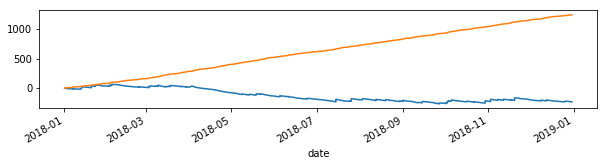

                               avg  bet  bets  profit  profit_place
idx_1    idx_2                                                     
HANDICAP final_odds_ref  0.4260597  637   637   271.4           4.9


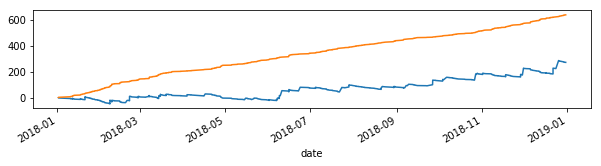

                              avg  bet  bets  profit  profit_place
idx_1   idx_2                                                     
INCONNU final_odds_ref -0.4121417  593   593  -244.4        -152.0


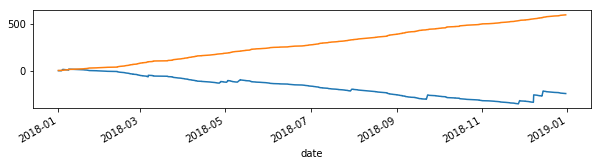

                                      avg  bet  bets  profit  profit_place
idx_1           idx_2                                                     
HANDICAP_DIVISE final_odds_ref -0.3128954  411   411  -128.6        -107.9


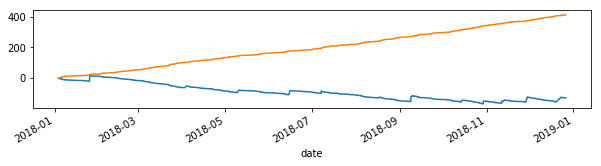

                                avg  bet  bets  profit  profit_place
idx_1     idx_2                                                     
AUTOSTART final_odds_ref -0.7320896  402   402  -294.3        -144.2


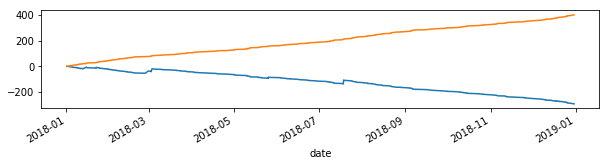

                                 avg  bet  bets  profit  profit_place
idx_1      idx_2                                                     
A_RECLAMER final_odds_ref -0.3183486  327   327  -104.1         -81.7


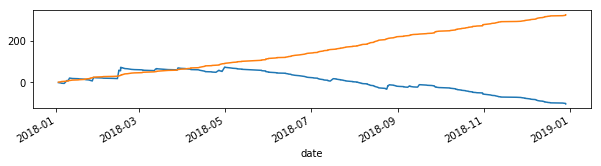

                                               avg  bet  bets  profit  \
idx_1                     idx_2                                         
HANDICAP_CATEGORIE_DIVISE final_odds_ref -0.388961  154   154   -59.9   

                                          profit_place  
idx_1                     idx_2                         
HANDICAP_CATEGORIE_DIVISE final_odds_ref          45.3  


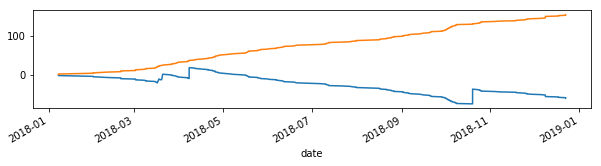

                                               avg  bet  bets  profit  \
idx_1                    idx_2                                          
INTERNATIONALE_AUTOSTART final_odds_ref -0.0931298  131   131   -12.2   

                                         profit_place  
idx_1                    idx_2                         
INTERNATIONALE_AUTOSTART final_odds_ref         -26.3  


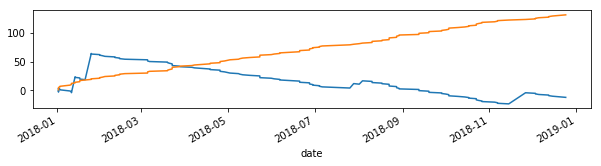

                                            avg  bet  bets  profit  \
idx_1                 idx_2                                          
HANDICAP_DE_CATEGORIE final_odds_ref -0.4050847  118   118   -47.8   

                                      profit_place  
idx_1                 idx_2                         
HANDICAP_DE_CATEGORIE final_odds_ref         -22.8  


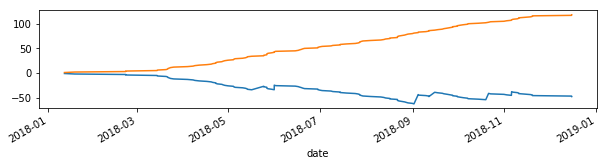

                                avg  bet  bets  profit  profit_place
idx_1     idx_2                                                     
NATIONALE final_odds_ref -0.3862069  116   116   -44.8         -37.8


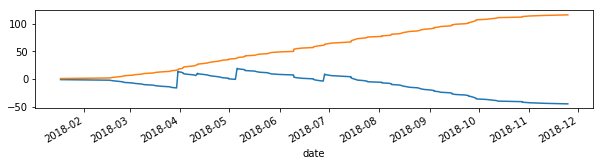

                                             avg  bet  bets  profit  \
idx_1                  idx_2                                          
APPRENTIS_LADS_JOCKEYS final_odds_ref  0.3844156   77    77    29.6   

                                       profit_place  
idx_1                  idx_2                         
APPRENTIS_LADS_JOCKEYS final_odds_ref          -4.3  


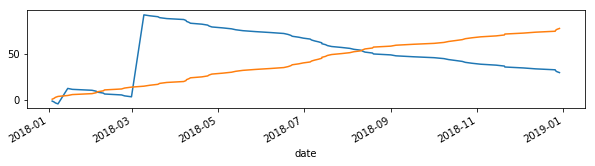

                                 avg  bet  bets  profit  profit_place
idx_1      idx_2                                                     
GROUPE_III final_odds_ref  0.3266667   60    60    19.6         -22.5


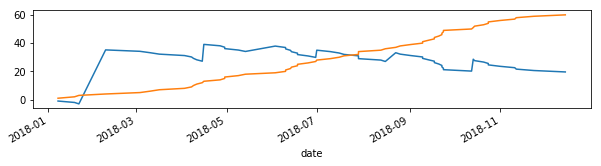

                                avg  bet  bets  profit  profit_place
idx_1     idx_2                                                     
GROUPE_II final_odds_ref -0.0466667   60    60    -2.8          -3.2


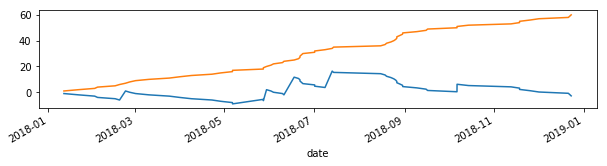

                                             avg  bet  bets  profit  \
idx_1                        idx_2                                    
COURSE_A_CONDITION_QUALIF_HP final_odds_ref -1.0   57    57   -57.0   

                                             profit_place  
idx_1                        idx_2                         
COURSE_A_CONDITION_QUALIF_HP final_odds_ref         -19.1  


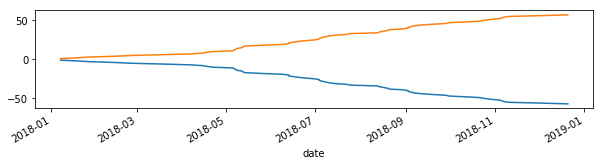

                               avg  bet  bets  profit  profit_place
idx_1    idx_2                                                     
GROUPE_I final_odds_ref -0.7978723   47    47   -37.5         -12.8


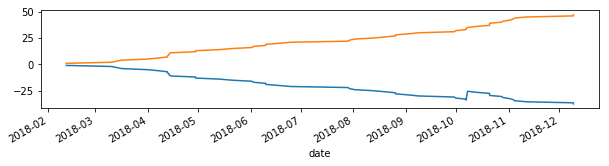

                                    avg  bet  bets  profit  profit_place
idx_1               idx_2                                               
NATIONALE_AUTOSTART final_odds_ref -1.0   45    45   -45.0         -19.4


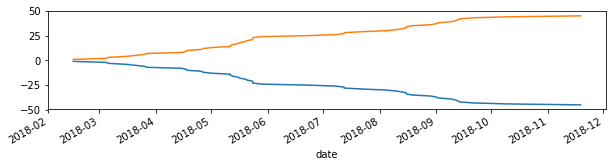

                           avg  bet  bets  profit  profit_place
idx_1      idx_2                                               
EUROPEENNE final_odds_ref -1.0   43    43   -43.0         -34.1


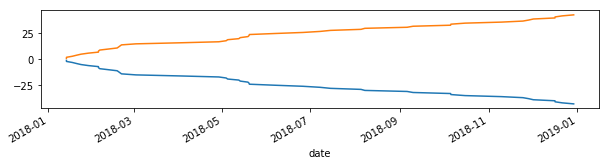

                               avg  bet  bets  profit  profit_place
idx_1    idx_2                                                     
AMATEURS final_odds_ref  0.7192308   26    26    18.7          -5.7


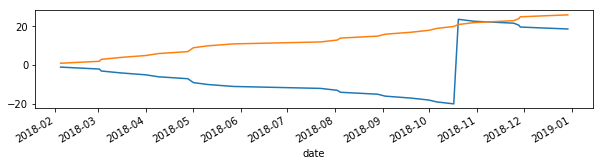

                                   avg  bet  bets  profit  profit_place
idx_1              idx_2                                               
AMATEURS_AUTOSTART final_odds_ref -1.0   24    24   -24.0          -3.6


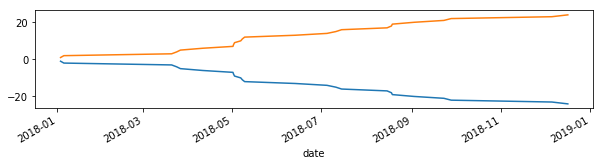

                               avg  bet  bets  profit  profit_place
idx_1          idx_2                                               
INTERNATIONALE final_odds_ref -1.0   16    16   -16.0          -7.5


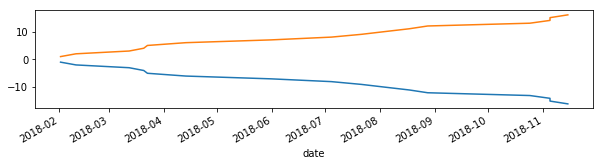

                                     avg  bet  bets  profit  profit_place
idx_1                idx_2                                               
EUROPEENNE_AUTOSTART final_odds_ref -1.0   16    16   -16.0         -16.0


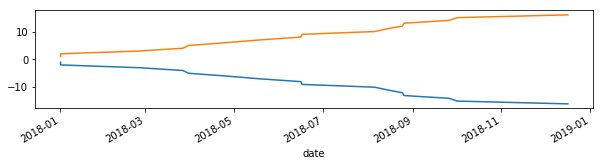

                                                 avg  bet  bets  profit  \
idx_1                            idx_2                                    
APPRENTIS_LADS_JOCKEYS_AUTOSTART final_odds_ref -1.0   11    11   -11.0   

                                                 profit_place  
idx_1                            idx_2                         
APPRENTIS_LADS_JOCKEYS_AUTOSTART final_odds_ref         -11.0  


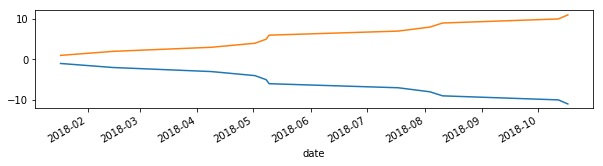

                                     avg  bet  bets  profit  profit_place
idx_1                idx_2                                               
A_RECLAMER_AUTOSTART final_odds_ref -1.0    8     8    -8.0          -8.0


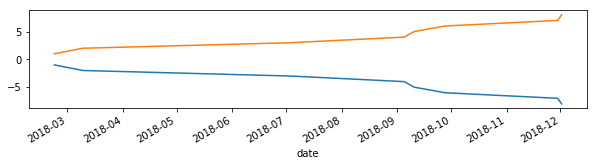

                                                  avg  bet  bets  profit  \
idx_1                             idx_2                                    
AMATEURS_INTERNATIONALE_AUTOSTART final_odds_ref -1.0    5     5    -5.0   

                                                  profit_place  
idx_1                             idx_2                         
AMATEURS_INTERNATIONALE_AUTOSTART final_odds_ref          -3.5  


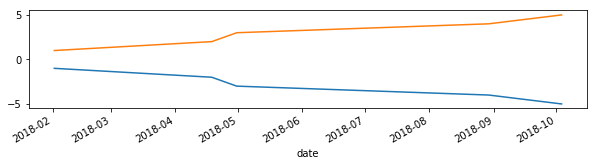

                                                  avg  bet  bets  profit  \
idx_1                             idx_2                                    
APPRENTIS_LADS_JOCKEYS_EUROPEENNE final_odds_ref -1.0    4     4    -4.0   

                                                  profit_place  
idx_1                             idx_2                         
APPRENTIS_LADS_JOCKEYS_EUROPEENNE final_odds_ref          -4.0  


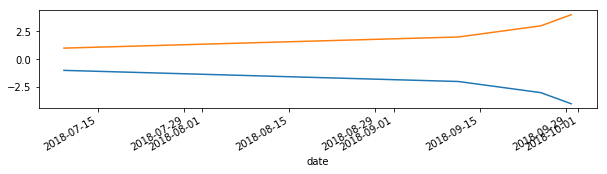

                                          avg  bet  bets  profit  profit_place
idx_1               idx_2                                                     
QUALIFICATION_ACCAF final_odds_ref  1.8333333    3     3     5.5           0.2


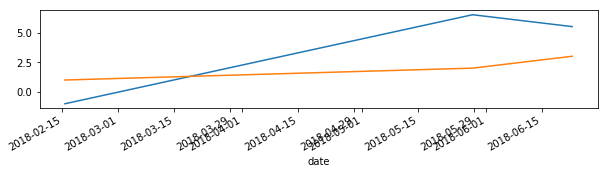

                                   avg  bet  bets  profit  profit_place
idx_1              idx_2                                               
AMATEURS_NATIONALE final_odds_ref -1.0    3     3    -3.0           3.8


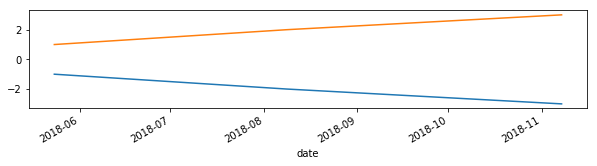

                                                  avg  bet  bets  profit  \
idx_1                             idx_2                                    
A_RECLAMER_APPRENTIS_LADS_JOCKEYS final_odds_ref -1.0    3     3    -3.0   

                                                  profit_place  
idx_1                             idx_2                         
A_RECLAMER_APPRENTIS_LADS_JOCKEYS final_odds_ref          -3.0  


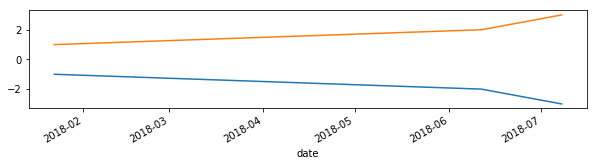

                                     avg  bet  bets  profit  profit_place
idx_1               idx_2                                                
HANDICAP_A_RECLAMER final_odds_ref  11.3    2     2    22.6           1.7


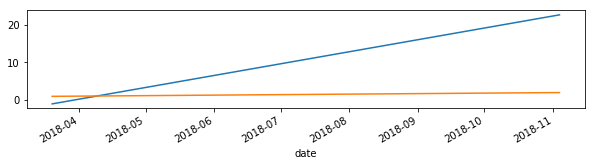

                          avg  bet  bets  profit  profit_place
idx_1     idx_2                                               
COURSE_AP final_odds_ref -1.0    2     2    -2.0          -2.0


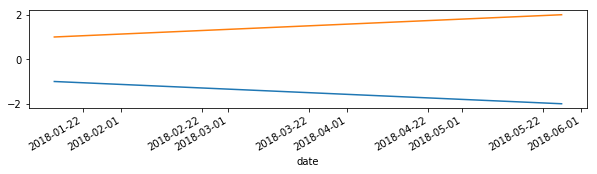

                                     avg  bet  bets  profit  profit_place
idx_1                idx_2                                               
COURSE_AP_EUROPEENNE final_odds_ref -1.0    1     1    -1.0          -1.0


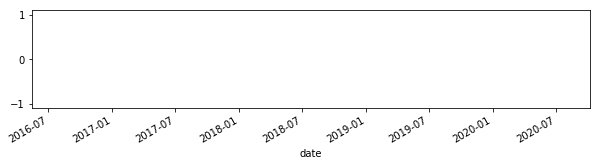

                                    avg  bet  bets  profit  profit_place
idx_1               idx_2                                               
AMATEURS_EUROPEENNE final_odds_ref -1.0    1     1    -1.0          -1.0


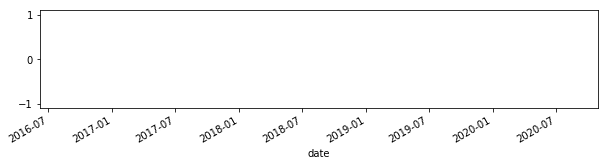

                                                            avg  bet  bets  \
idx_1                                       idx_2                            
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART final_odds_ref -1.0    1     1   

                                                            profit  \
idx_1                                       idx_2                    
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART final_odds_ref    -1.0   

                                                            profit_place  
idx_1                                       idx_2                         
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART final_odds_ref          -1.0  


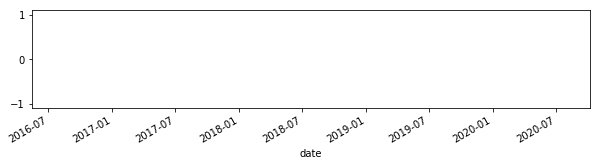

In [105]:
#bb = bets[(bets['nb']==1) & (bets['odds_ref'] > 1) & (bets['odds_ref'] > bets['final_odds_ref_offline']) & (bets['odds_ref'] < 20) & (bets['sub_category']!='kCOURSE_A_CONDITIONS') & (bets['pred'] > 1) & (bets['pred'] < 200) & (bets['target']!='final_odds_ref')   ].copy()

bb = bets[(bets['nb']==1) & (bets['odds_ref'] > 1) & ((bets['odds_ref'] > bets['final_odds_ref_offline'])) & (bets['final_odds_ref_unibet'] < 40) & (bets['sub_category']!='kCOURSE_A_CONDITIONS') & (bets['pred'] > 10) & (bets['pred'] < 500) & (bets['target']=='final_odds_ref')   ].copy()


#bb = bb.groupby('id').filter(lambda b: len(b) <3 )
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_stacked_mlp_relu_1') & (bets['odds_ref']<30) & (bets['odds_ref']>10) & (bets['pred']>0)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()


# ok
#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_3']) & (bets['odds_ref']<20) & (bets['target']=='pred_knn_10_2') ].copy()


#bb = bets[ (bets['country']!='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']>=3) & (bets['nb']<=3) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']=='pred_stacked_mlp_sigmoid_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * bb['pred']
#bb['bet'] = bb['bet'] * bb['pred']

graph_bb(bb, 'sub_category')




In [ ]:
bb[bb['declared_player_count']<10]['profit'].mean()


In [ ]:
program.df['category'].value_counts()

In [ ]:
mode = 'INTERNET'
mode.lower()